In [16]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [17]:
#TODO: make the loading/oversampling etc into a function
#TODO: try adding respiratory features 

* ``ECG_Rate_Mean``: the mean heart rate.
* **MeanNN**: The mean of the RR intervals.
* **SDNN**: The standard deviation of the RR intervals.
* **SDANN1**, **SDANN2**, **SDANN5**: The standard deviation of average RR intervals
  extracted from n-minute segments of time series data (1, 2 and 5 by default). Note that
  these indices require a minimal duration of signal to be computed (3, 6 and 15 minutes
  respectively) and will be silently skipped if the data provided is too short.
* **SDNNI1**, **SDNNI2**, **SDNNI5**: The mean of the standard deviations of RR intervals
  extracted from n-minute segments of time series data (1, 2 and 5 by default). Note that
  these indices require a minimal duration of signal to be computed (3, 6 and 15 minutes
  respectively) and will be silently skipped if the data provided is too short.
* **RMSSD**: The square root of the mean of the squared successive differences between
  adjacent RR intervals. It is equivalent (although on another scale) to SD1, and
  therefore it is redundant to report correlations with both (Ciccone, 2017).
* **SDSD**: The standard deviation of the successive differences between RR intervals.
* **CVNN**: The standard deviation of the RR intervals (**SDNN**) divided by the mean of
  the RR intervals (**MeanNN**).
* **CVSD**: The root mean square of successive differences (**RMSSD**) divided by
  the mean of the RR intervals (**MeanNN**).
* **MedianNN**: The median of the RR intervals.
* **MadNN**: The median absolute deviation of the RR intervals.
* **MCVNN**: The median absolute deviation of the RR intervals (**MadNN**) divided by the
  median of the RR intervals (**MedianNN**).
* **IQRNN**: The interquartile range (**IQR**) of the RR intervals.
* **SDRMSSD**: SDNN / RMSSD, a time-domain equivalent for the low Frequency-to-High
  Frequency (LF/HF) Ratio (Sollers et al., 2007).
* **Prc20NN**: The 20th percentile of the RR intervals (Han, 2017; Hovsepian, 2015).
* **Prc80NN**: The 80th percentile of the RR intervals (Han, 2017; Hovsepian, 2015).
* **pNN50**: The proportion of RR intervals greater than 50ms, out of the total number of
  RR intervals.
* **pNN20**: The proportion of RR intervals greater than 20ms, out of the total number of
  RR intervals.
* **MinNN**: The minimum of the RR intervals (Parent, 2019; Subramaniam, 2022).
* **MaxNN**: The maximum of the RR intervals (Parent, 2019; Subramaniam, 2022).
* **TINN**: A geometrical parameter of the HRV, or more specifically, the baseline width of
  the RR intervals distribution obtained by triangular interpolation, where the error of
  least squares determines the triangle. It is an approximation of the RR interval
  distribution.
* **HTI**: The HRV triangular index, measuring the total number of RR intervals divided by
  the height of the RR intervals histogram.



In [18]:
data = pd.read_csv('feat_0002.csv')


'''
'''

columns2 = ['ECG_Rate_Mean','HRV_MeanNN','HRV_SDNN','HRV_RMSSD']
columns1 = ['ECG_Rate_Mean','HRV_MeanNN','HRV_SDNN','HRV_RMSSD','HRV_Prc20NN','HRV_Prc80NN','HRV_MinNN','HRV_MaxNN']
features = len(columns2)
X = data[columns2]
y = data.labels2

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

#somehow it's better with only mean HR as the feature LOL
#and also before scaling ..??? 

#i'll have to figure out how to tune this more systematically

In [19]:
data.groupby('labels2').size()
#unbalanced data :( 

labels2
0    284
1    748
dtype: int64

In [20]:


# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into train and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Train set size: 618
Validation set size: 207
Test set size: 207


In [21]:


# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the number of samples in each class after oversampling
print("Counts of label '1' before oversampling:", sum(y_train == 0))
print("Counts of label '2' before oversampling:", sum(y_train == 1))

print("Counts of label '1' after oversampling:", sum(y_resampled == 0))
print("Counts of label '2' after oversampling:", sum(y_resampled == 0))


Counts of label '1' before oversampling: 156
Counts of label '2' before oversampling: 462
Counts of label '1' after oversampling: 462
Counts of label '2' after oversampling: 462


In [22]:

#tuning: gamma, C, kernel, oversampling method 

# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=0.1, C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_resampled, y_resampled)

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_val)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.8888888888888888


F1 Score:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        62
           1       0.93      0.91      0.92       145

    accuracy                           0.89       207
   macro avg       0.86      0.87      0.87       207
weighted avg       0.89      0.89      0.89       207

Confusion Matrix:


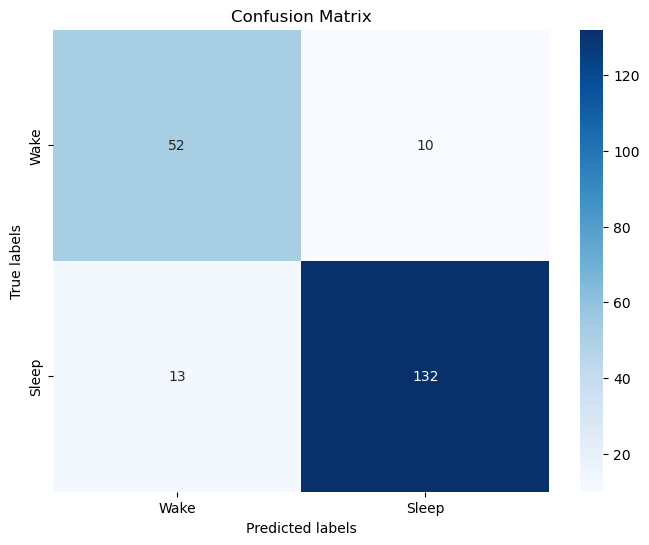

In [23]:


# Calculate F1-score
f1_score = classification_report(y_val, y_pred)
print("F1 Score:")
print(f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")


import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Wake','Sleep'],
            yticklabels=['Wake','Sleep'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [24]:
#TRY MLP

# Initialize MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(32,16,), activation='relu', solver='adam', 
                               alpha=0.0001, batch_size='auto', learning_rate='adaptive', 
                               learning_rate_init=0.01, max_iter=400, random_state=42)

# Train the classifier
mlp_classifier.fit(X_resampled, y_resampled)


# Predict labels for training set
y_pred_train = mlp_classifier.predict(X_resampled)

# Evaluate accuracy on training set
train_accuracy = accuracy_score(y_resampled, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Predict labels for training set
y_pred_val = mlp_classifier.predict(X_val)

# Evaluate accuracy on training set
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_accuracy)

#validation accuracy is higher bc validation set is not balanced!! 
#LOL these performed exactly the same 


Training Accuracy: 0.8939393939393939
Validation Accuracy: 0.8260869565217391


F1 Score:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        62
           1       0.90      0.85      0.87       145

    accuracy                           0.83       207
   macro avg       0.79      0.81      0.80       207
weighted avg       0.83      0.83      0.83       207

Confusion Matrix:


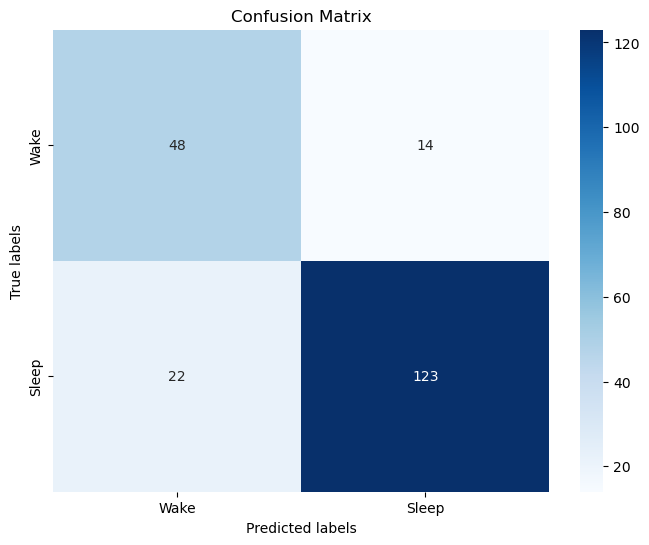

In [25]:


# Calculate F1-score
f1_score = classification_report(y_val, y_pred_val)
print("F1 Score:")
print(f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Wake','Sleep'],
            yticklabels=['Wake','Sleep'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [26]:
#try with 4 classes

y = data.labels4


# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
# Further split the training set into train and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12)


# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("original")
for i in range(4):
    print(i,': ', sum(y_train == i))
print("resampled")
for i in range(4):
    print(i,': ', sum(y_resampled == i))


# Initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=0.1, C=1, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_resampled, y_resampled)

# Predict the labels for the test set
y_pred = svm_classifier.predict(X_val)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)



original
0 :  174
1 :  246
2 :  90
3 :  108
resampled
0 :  246
1 :  246
2 :  246
3 :  246
Accuracy: 0.5652173913043478


F1 Score:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        54
           1       0.69      0.51      0.58        75
           2       0.35      0.74      0.47        34
           3       0.45      0.23      0.30        44

    accuracy                           0.57       207
   macro avg       0.56      0.57      0.54       207
weighted avg       0.60      0.57      0.56       207

Confusion Matrix:


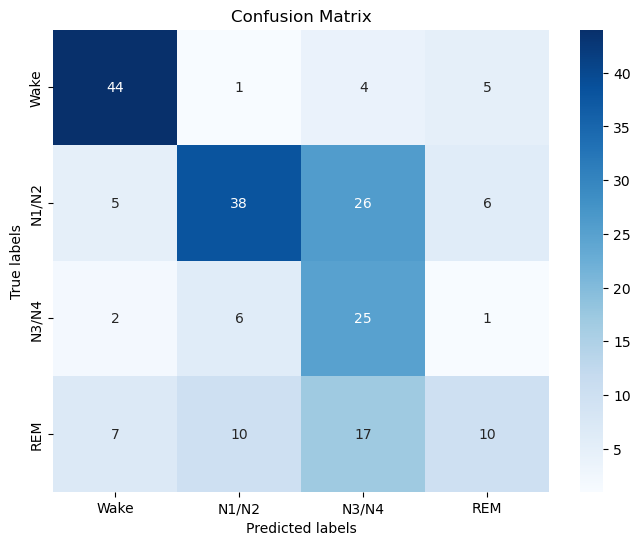

In [27]:


# Calculate F1-score
f1_score = classification_report(y_val, y_pred)
print("F1 Score:")
print(f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Wake','N1/N2','N3/N4','REM'],
            yticklabels=['Wake','N1/N2','N3/N4','REM'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:


# Initialize MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(32,16,), activation='relu', solver='adam', 
                               alpha=0.0001, batch_size='auto', learning_rate='adaptive', 
                               learning_rate_init=0.005, max_iter=400, random_state=42)

# Train the classifier
mlp_classifier.fit(X_resampled, y_resampled)


# Predict labels for training set
y_pred_train = mlp_classifier.predict(X_resampled)

# Evaluate accuracy on training set
train_accuracy = accuracy_score(y_resampled, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Predict labels for training set
y_pred_val = mlp_classifier.predict(X_val)

# Evaluate accuracy on training set
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_accuracy)


Training Accuracy: 0.7266260162601627
Validation Accuracy: 0.6038647342995169


F1 Score:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        54
           1       0.64      0.51      0.57        75
           2       0.42      0.65      0.51        34
           3       0.53      0.52      0.53        44

    accuracy                           0.60       207
   macro avg       0.60      0.61      0.60       207
weighted avg       0.63      0.60      0.61       207

Confusion Matrix:


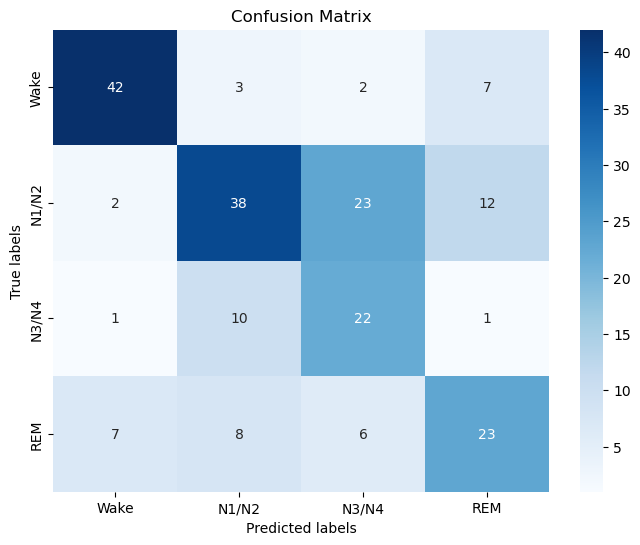

In [29]:


# Calculate F1-score
f1_score = classification_report(y_val, y_pred_val)
print("F1 Score:")
print(f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Wake','N1/N2','N3/N4','REM'],
            yticklabels=['Wake','N1/N2','N3/N4','REM'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
